# Examen 2 - Parte I: Tratamiento de datos

### Juan David García Hernández 201529083 - César Daniel Garrido Urbano 201531367

El presente _notebook_ contiene el reporte y solución (código) de la primera parte, de cuatro, del examen 2 del curso de Machine Learning de la Universidad de los Andes. En este se busca resolver el problema de clasificación multiclase de estados de sueño a partir de lectura de datos de EEG. Adicional a estos cuatro _notebooks_ se cuenta con un repositorio en donde se recopilan todos los códigos utilizados, incluso algunos que por facilidad en la expliación del proceso en el que se resolvió el examen, no se encuentran adjuntos en los reportes de Jupyter. A este repositorio se puede acceder utilizando el siguiente enlace: https://gitlab.com/JuanDavidG1997/eeg_sleepclassification.git

En esta primera parte se se presenta el tratamiento que se le da a los datos antes de construir los modelos de clasificación. En primer lugar, se hace la lectura de los datos, utilizando la librería $\texttt{pyedflib}$, en ventanas de tiempo de 30 segundos y se hace una observación preliminar de los mismos. En segundo lugar, con base en una revisión de la literatura, se escojen las carácteristicas que se desean extraer de las ventanas de tiempo de 30 segundos y se estandarizan las clases con las que se va a trabajar. En otras palabras, se construyen los archivos de caracteristicas (X) y de etiquetas (Y). En tercer lugar, se observa la cantidad de datos con los que se trabaja, se hace un balance de las clases y se separan en datos de entrenamiento, validación y prueba. Finalmente, se exportan los datos definitivos a 6 nuevos archivos csv (XTrain, YTrain, XVal, YVal, XTest y YTest), con los cuales se va a trabajar en las otras secciones de este examen para construir, seleccionar y probar los modelos de clasificación.

In [1]:
# Librerías
import pyedflib as pyedf
import numpy as np
import matplotlib.pyplot as plt
import nitime.algorithms as alg
import random as rand
import pyeeg
import csv
from scipy.fftpack import fft
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split

## Lectura preliminar de datos

Para empezar y tener una idea preliminar de los datos, estos se gráfican en las ventanas de 30 segundos con las que se van a trabajar. Ahora bien, con el objetivo de no sobrecargar visualmente las gráficas se seleccionan de forma aleatoria algunas muestras para observarlas. Vale la pena aclarar que esto se hizo únicamente con el objetivo de visualizar y familiarizarse con los datos. Asimismo, en este punto se definio el formato de las etiquetas y de las clases, las cuales se definen de la siguiente manera:

* Clase 0 (Despierto): Sleep stage W
* Clase 1 (Sueño ligero): Sleep stage 1, Sleep stage 2 
* Clase 2 (Sueño profundo): Sleep stage 3, Sleep stage 4
* Clase 3 (Sueño REM): Sleep stage R

Las demás etiquetas fueron descartadas por completo. A continuación se muestra un ejemplo del código que se utilizo.

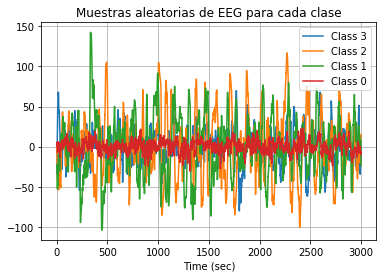

In [2]:
# -------------------------------- ETIQUETAS --------------------------------
# Lectura del archivo de estados de sueño (etiquetas)
st_FileHypEdf = pyedf.EdfReader("../Data/sleep-cassette/SC4001EC-Hypnogram.edf")
v_HypTime, v_HypDur, v_Hyp = st_FileHypEdf.readAnnotations()
# Número de ventanas de 30seg
nWindows = v_HypTime[-1]/30
# Vector de etiquetas
YTrain = []
# Se recorre y se llena el vector YTrain
time = 0
index = 0
for i in range(0,int(nWindows)):
    # Si la variable tiempo cambia de etiqueta se aumenta el indice
    if not(time >= v_HypTime[index] and time < v_HypDur[index]) and (index<152):
        index += 1
    # Se cambia la nomenclatura
    label = v_Hyp[index]
    if label == 'Sleep stage W':
        YTrain.append(0)
    elif label == 'Sleep stage 1' or label == 'Sleep stage 2':
        YTrain.append(1)
    elif label == 'Sleep stage 3' or label == 'Sleep stage 4':
        YTrain.append(2)
    if label == 'Sleep stage R':
        YTrain.append(3)
    # Se avanza en el tiempo
    time += 30
# -------------------------------- DATOS --------------------------------
# Vector de Datos
XTrain = []
XTimeTrain = []
# Lectura de las señales s_SigNum señales con nombres v_Signal_Labels
st_FileEdf = pyedf.EdfReader("../Data/sleep-cassette/SC4001E0-PSG.edf")
s_SigNum = st_FileEdf.signals_in_file
v_Signal_Labels = st_FileEdf.getSignalLabels()
# Conversion a segundos usando frecuencia de muestreo.
s_SigRef = 0
s_NSamples = st_FileEdf.getNSamples()[0]
s_FsHz = st_FileEdf.getSampleFrequency(s_SigRef)
v_Sig = st_FileEdf.readSignal(s_SigRef)
v_Time = np.arange(0, s_NSamples) / s_FsHz
s_WinSizeSec = 30
s_WinSizeSam = np.round(s_FsHz * s_WinSizeSec)
# Se construye vector de datos y tiempo de vector de datos
s_FirstInd = 0
while 1:
    s_LastInd = s_FirstInd + s_WinSizeSam
    if s_LastInd > s_NSamples:
        break
    XTimeTrain.append(v_Time[s_FirstInd:s_LastInd])
    XTrain.append(v_Sig[s_FirstInd:s_LastInd])
    s_FirstInd = s_LastInd
# -------------------------------- Gráficas --------------------------------
# Dominio del tiempo
plt.figure()
plt.title('Muestras aleatorias de EEG para cada clase')
plt.xlabel('Time (sec)')
plt.grid()
randSample = []
indexClass = [index for index, value in enumerate(YTrain) if value == 3]
randSample.append(rand.sample(indexClass, k=1)[0])
indexClass = [index for index, value in enumerate(YTrain) if value == 2]
randSample.append(rand.sample(indexClass, k=1)[0])
indexClass = [index for index, value in enumerate(YTrain) if value == 1]
randSample.append(rand.sample(indexClass, k=1)[0])
indexClass = [index for index, value in enumerate(YTrain) if value == 0]
randSample.append(rand.sample(indexClass, k=1)[0])
# Gráficar datos
for i in randSample:
    plt.plot(XTrain[i])
plt.legend(['Class 3','Class 2','Class 1','Class 0'])
plt.show()

Con base en lo que se puede observar, se resaltan algunas características que varían entre señales, como lo son: la amplitud, los valores máximos y mínimos, el valor medio, el número de picos, entre otros. No obstante, no se puede notar un patrón o un comportamiento que detalle una diferencia significativa, al menos en esta visualización en el dominio del tiempo. De esta manera, se procede a hacer también una visualización de estas señales en el dominio de la frecuencia, utilizando la transformada de fourier ($\texttt{FFT}$), de la librería de _scipy._

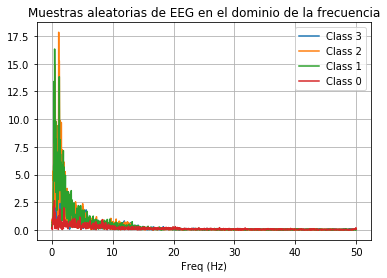

In [3]:
# Dominio de la frecuencia
plt.figure()
plt.title('Muestras aleatorias de EEG en el dominio de la frecuencia')
plt.xlabel('Freq (Hz)')
plt.grid()
for i in randSample:
    freqAxis = np.linspace(0.0, 1.0/(2.0*(1/100)), 3000//2)
    XFTrain = 2.0/3000 * np.abs(fft(XTrain[i])[0:3000//2])
    plt.plot(freqAxis,XFTrain)
plt.legend(['Class 3','Class 2','Class 1','Class 0'])

plt.show()

A pesar de que se pueden encontrar diferencias más claras entre las señales, algunas frecuencias presentes únicamente en las clases 2 y 3 o un ruido cosntante en laclase 0, no se puede generalizar el comportamiento de las mismas a partir de una tan muestra y aleatoria. Sin embargo, queda claro que el comportamiento en el dominio de la frecuencia será una característica valiosa para el análisis. 

## Selección de carácteristicas

A partir del análisis preliminar de los datos, se determina que se necesita ayuda de la literatura relacionada con el tema para poder extraer las caracteristicas que se desean de las señales de EEG. Con esto en mente, y al ser un tema de relativo desconocimiento para el equipo de trabajo, se propone extraer el mayor número de caracteristicas. Esto con el fin de poder extraer la mayor cantidad de información relevante de las señáles de entrada y, si es necesario, posteriormente reducir características utilizando métodos de preprocesamiento como PCA.

De esta manera, en [2] y en [3] se sugieren alrededor de 11 características para el analisis de señales EMG  (similares al EEG), las cuales incluyen tanto valores escalares como coeficientes, de los cuales se tomaron siempre los 10 primeros. El detalle de como calcular cada una de estas caracteristicas se encuentra en [3], y a pesar de que el mismo articulo concluye sobre que tan buenas son algunas de estas caracteristicas, sugiere que lo mejor es una combinación de varias, por lo que como se menciona anteriormente se incluyen todas para este proyecto. Adicionalmente, para el cálculo de algunas de estas caracteristicas fueron necesarias librerías como _nitime_ y _pyEEG,_ ambas librerías de python dedicadas para el análisis de imagenes de neurociencia y señales de EEG. De forma especifica, la segunda ofrece no solo una documentación sino todo un marco teórico alrededor de la lectura de estas señales [1]. Así las cosas, adicional a las 11 caracteristicas del primer articulo, se incluye una gran cantidad de caracteristicas que ofrece la librería de _pyEEG,_ las cuales incluyen también coeficientes en el dominio de frecuencia. Vale la pena mencionar que todos los parámetros de estas caracteristicas (como los mV mínimos de la amplitud de willison o las bandas de frecuencia en la intensidad de poder espectral, entre otras) se ajustaron utilizando la información de los mismos articulos.

Finalmente, todas estas caracteristicas se sintetizan en la función que se presenta a continuación, la cual recibe como entrada la señal en tiempo de 30 segundos y devuelve un vector de 51 caracteristicas asociadas a la señal de entrada. 

In [4]:
# Método para la extracción de características
def extractFeatures(X):
    XFeatures = []
    # Mean absolute value and mean value
    XFeatures.append(np.mean(np.abs(X)))
    XFeatures.append(np.mean(X))
    # Max and min values
    XFeatures.append(np.amax(X))
    XFeatures.append(np.amin(X))
    # Zero-Crossing
    XFeatures.append(len(np.where(np.diff(np.sign(X)))[0]))
    # Slope sign changes
    XFeatures.append(len(np.where(np.logical_and(np.sign(np.diff(X)), np.abs(np.diff(X))>15))[0]))
    # Wave length
    XFeatures.append(np.sum(np.abs(np.diff(X))))
    # Willison Amplitude
    XFeatures.append(np.sum(np.where(np.abs(np.diff(X))>50)[0]))
    # Variance
    XFeatures.append(np.var(X))
    # Log detect
    XFeatures.append(np.exp((np.sum(np.log(np.abs(X))))/len(X)) )
    # Histogram
    hist = np.histogram(X)[0]
    for h in hist:
        XFeatures.append(h)
    # Autoregression Coeficient
    ARCoef = alg.autoregressive.AR_est_LD(X,10)[0]
    for ar in ARCoef:
        XFeatures.append(ar)
    # Cepstrum coefficients
    cepCoef = [-ARCoef[0]]
    sum = 0
    for i in range(1,10):
        sum = 0
        for l in range(1,i-1):
            sum += (1-l/i)*ARCoef[l]*cepCoef[i-1]
        cepCoef.append(-ARCoef[i] - sum)
    for c in cepCoef:
        XFeatures.append(c)

    # Petrosian Fractal Dimension
    XFeatures.append(pyeeg.pfd(X))
    # Higuchi Fractal Dimension
    XFeatures.append(pyeeg.hfd(X,10))
    # Hjorth mobility and complexity
    hjorth = pyeeg.hjorth(X)
    XFeatures.append(hjorth[0])
    XFeatures.append(hjorth[1])
    # Power Spectral Intensity and Relative Intensity Ratio
    band =[0.5, 4, 7, 12, 30]
    bPower = pyeeg.bin_power(X,band,s_FsHz)
    for bp in bPower[1]:
        XFeatures.append(bp)
    # Spectral Entropy (Shannon’s entropy of RIRs)
    sEntropy = pyeeg.spectral_entropy(X,band,s_FsHz, bPower[1])
    XFeatures.append(sEntropy)
    #Fisher Information
    XFeatures.append(pyeeg.fisher_info(X,2,20))
    # Detrended Fluctuation Analysis
    XFeatures.append(pyeeg.dfa(X))
    # HurstExponent(Hurst)
    #XFeatures.append(pyeeg.hurst(X))
    return XFeatures

De esta manera, con esta función se leen todos los datos del data set (sleep-cassette) y se guardan en un archivo como nuevos vectores de 51 dimensiones por observación. A continuación se presenta un ejemplo del código que se empleo para esta tarea. No obstante, vale la pena destacar que este en este _notebook_ se presenta únicamente un ejemplo con uno de los archivos, pues el leer todos los 152 archivos toma un tiempo (y poder computacional) considerable por lo que se hizo previamente por fuera del framework de jupyter. Sin embargo, la idea implementada es la misma.

In [5]:
from IPython.display import clear_output
path = "../Data/sleep-cassette/"
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
onlyfiles.sort()
print("Found " + str(len(onlyfiles)) + " files.")
counter = 0
while counter < len(onlyfiles):
    #auxiliar vectors
    signal = []
    time = []
    tag = []
    print("Loading files: %.2f " % (counter*100/len(onlyfiles)))
    # Reading Hypogram file
    #st_FileHypEdf = pyedf.EdfReader(path + str(onlyfiles[counter+1]))
    # Setting time, duration and tags
    #v_HypTime, v_HypDur, v_Hyp = st_FileHypEdf.readAnnotations()
    # PSG Data
    #st_FileEdf = pyedf.EdfReader(path + str(onlyfiles[counter]))
    #s_SigNum = st_FileEdf.signals_in_file
    #v_Signal_Labels = st_FileEdf.getSignalLabels()
    #s_SigRef = 0
    #s_NSamples = st_FileEdf.getNSamples()[0]
    #s_FsHz = st_FileEdf.getSampleFrequency(s_SigRef)
    #v_Sig = st_FileEdf.readSignal(s_SigRef)
    #v_Time = np.arange(0, s_NSamples) / s_FsHz
    # Real vectors
    signalDef = []
    tagDef = []
    # Window span 30 secs
    windowLen = 30

    for i in range(0,len(v_Hyp)-1):
        # Special case
        if i < len(v_Hyp) - 2:
            # Appends each sleep stage separately
            signal.append(v_Sig[(np.where(v_Time==v_HypTime[i])[0][0]):(np.where(v_Time==v_HypTime[i+1])[0][0])])
            time.append(v_Time[(np.where(v_Time==v_HypTime[i])[0][0]):(np.where(v_Time==v_HypTime[i+1])[0][0])])
        else:
            signal.append(v_Sig[(np.where(v_Time==v_HypTime[i])[0][0]):])
            time.append(v_Time[(np.where(v_Time==v_HypTime[i])[0][0]):])
        # Append respective tag
        tag.append(v_Hyp[i])
    # Two iterations given 2 read files
    counter = counter + 2

    for j in range(0, len(time)):
        time[j] = time[j]-time[j][0]
        # Checks important sleep stages
        if tag[j] == 'Sleep stage ?':
            # Jumps to next sleep stage
            continue
        elif tag[j] == 'Movement time':
            # Jumps to next sleep stage
            continue
        for i in range(0, int(time[j][-1]/windowLen)):
            # Special case
            # Appends i'th second window of signal
            if i < (time[j][-1]/windowLen)-1:
                signalDef.append(signal[j][(np.where(time[j]==windowLen*i)[0][0]):(np.where(time[j]==windowLen*(i+1))[0][0])])
            else:
                signalDef.append(signal[j][(np.where(time[j]==windowLen*i)[0][0]):])
            # Appends class according to sleep stage
            y = -1
            if tag[j] == 'Sleep stage W':
                y = 0
            elif tag[j] == 'Sleep stage 1' or tag[j] == 'Sleep stage 2':
                y = 1
            elif tag[j] == 'Sleep stage 3' or tag[j] == 'Sleep stage 4':
                y = 2
            elif tag[j] == 'Sleep stage R':
                y = 3
            elif tag[j] == 'Sleep stage ?':
                y = 4
                print("Error")
            else:
                print(tag[j])
                print("Failed at tag setting")
                break
            tagDef.append(y)

    # Feature extraction process
    features = []
    for i in signalDef:
        features.append(extractFeatures(np.array(i)))

    # Writes data file
    with open('../Data/Example/features.csv', mode='a') as x_file:
        x_writer = csv.writer(x_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for i in range(0, len(features)):
            x_writer.writerow(features[i])

    #Writes tag file
    with open('../Data/Example/tags.csv', mode='a') as y_file:
        y_writer = csv.writer(y_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        for i in tagDef:
            y_writer.writerow([i])
            
clear_output()
print("Características extraidas de los datos originales exitosamente")

Características extraidas de los datos originales exitosamente


## Balance y separación de datos

Por último, una vez los datos se han depurado y se presentan en forma de sus caracteristicas, se procede a observar la distribución y balance de las clases. Para esto se cuenta el número y porcentaje en el que estan distribuidos los datos entre las cuatro clases como se muestra a continuación.

In [6]:
# Data loading
rawX = np.genfromtxt('../../Data/features.csv', delimiter=',')
rawY = np.genfromtxt('../../Data/tags.csv', delimiter=',')

awakeCount = len(rawY) - np.count_nonzero(rawY)
sleep1Count = np.count_nonzero(rawY==1)
sleep2Count = np.count_nonzero(rawY==2)
sleepRCount = np.count_nonzero(rawY==3)

def displaySummary(awakeCount, sleep1Count, sleep2Count, sleepRCount):
    print("Numero de elementos clase 0 (Despierto): " + str(awakeCount) + " (" + str(round(100*awakeCount/len(rawY),2)) + "%  del total de datos)")
    print("Numero de elementos clase 1 (Sueno ligero): " + str(sleep1Count) + " (" + str(round(100*sleep1Count/len(rawY),2)) + "% del total de datos)")
    print("Numero de elementos clase 2 (Sueno profundo): " + str(sleep2Count) + " (" + str(round(100*sleep2Count/len(rawY),2)) + "% del total de datos)")
    print("Numero de elementos clase 3 (Sueno REM): " + str(sleepRCount) + " (" + str(round(100*sleepRCount/len(rawY),2)) + "% del total de datos)")

# Balancing data
displaySummary(awakeCount, sleep1Count, sleep2Count, sleepRCount)

Numero de elementos clase 0 (Despierto): 280906 (71.47%  del total de datos)
Numero de elementos clase 1 (Sueno ligero): 79346 (20.19% del total de datos)
Numero de elementos clase 2 (Sueno profundo): 8486 (2.16% del total de datos)
Numero de elementos clase 3 (Sueno REM): 24275 (6.18% del total de datos)


En este caso, se observa un claro desbalance en la distribución de los datos.  Donde la clase 0 (Despierto) agrupa una gran cantidad de datos (más del 70%) y las clases 2 y 3 (Sueño profundo y REM) acapaaran muy pocos datos (menos del 10% entre las dos). Dada la gran cantidad de datos que se tienen de la primera clase, se toma la decisión de eliminar de manera aleatoria la mitad de los datos de esta clase. Usualmente, en un problema de aprendizaje supervisado se desea tener la mayor cantidad de datos posible. No obstante, el problema en cuestión presenta una gran cantidad de datos y el tener las clases tan desbalanceadas puede presentar dificultades al momento del entrenamiento. En primer lugar, el tener clases tan desbalanceadas puede causar que los modelos de clasificación utilizados se concentren únicamente en la clase 0 y no aprendan tan bien las clases minoritarias (2 y 3). En segundo lugar, el tener tantos datos puede retrasar el proceso de entrenamiento en terminos computacionales y dado el tiempo que se tiene para solucionar el problema se desea mejorar dicho factor en la mayor medida posible. 

Ahora bien, el reducir los datos de la clase 0 a la mitad, evidentemente, no balancea por completo la distribución de las clases. Razón por la cual, con los datos restantes, se determinan los pesos para cada dato por clase. Esto con el fin de poder hacer un entrenamiento pesado de los datos, si así se desea y de igual forma tener los pesos como medida de evaluación al momento de evaluar el error de los clasificadores. De esta manera se puede comprobar que la clasificación que se esta haciendo no se enfoca únicamente en la clase mayoritaria sino que los modelos efectivamente tienen también un buen desempeño clasificando las clases con menos datos. Por último, se separan y se reservan datos para entrenamiento, validar y prueba, los cuales se utilizaran a lo largo de las demás secciones del examen, para entrenar modelos, hacer la selección adecuada del modelo y finalmente hacer la estimación del error de los mejores modelos.

In [7]:
print("Balanceando datos...")
delIndex = []
for i, y in enumerate(rawY):
    r = rand.random()
    if y == 0 and r > 0.5:
        delIndex.append(i)
rawY = np.delete(rawY,delIndex)
rawX = np.delete(rawX,delIndex, axis=0)
awakeCount = len(rawY) - np.count_nonzero(rawY)
sleep1Count = np.count_nonzero(rawY==1)
sleep2Count = np.count_nonzero(rawY==2)
sleepRCount = np.count_nonzero(rawY==3)

displaySummary(awakeCount, sleep1Count, sleep2Count, sleepRCount)

# Spliting training data
XTrain, newRawX, YTrain, newRawY = train_test_split(rawX, rawY, test_size=0.20)
# Spliting validation and test data
XTest, XVal, YTest, YVal = train_test_split(newRawX, newRawY, test_size=0.50)
# Shaping into column vectors
YTest = YTest.reshape(-1, 1)
YVal = YVal.reshape(-1, 1)

class_weight = [float(1.0/awakeCount), float(1.0/sleep1Count), float(1.0/sleep2Count), float(1.0/sleepRCount)]

print(class_weight)

weigthsY = []
weigthsYVal = []
weigthsYTest = []
for i in YTrain:
    weigthsY.append(class_weight[int(i)])

for i in YVal:
    weigthsYVal.append(class_weight[int(i)])

for i in YTest:
    weigthsYTest.append(class_weight[int(i)])

#Saving data in csv files
#np.savetxt("Data/X.csv", XTrain, delimiter=",")
#np.savetxt("Data/Y.csv", YTrain, delimiter=",")
#np.savetxt("Data/XVal.csv", XVal, delimiter=",")
#np.savetxt("Data/YVal.csv", YVal, delimiter=",")
#np.savetxt("Data/XTest.csv", XTest, delimiter=",")
#np.savetxt("Data/Ytest.csv", YTest, delimiter=",")
#np.savetxt("Data/weigthsY.csv", weigthsY, delimiter=",")
#np.savetxt("Data/weigthsYVal.csv", weigthsYVal, delimiter=",")
#np.savetxt("Data/weigthsYTest.csv", weigthsYTest, delimiter=",")
# Inform user
print("Datos separados y almacenados de manera correcta...")


Balanceando datos...
Numero de elementos clase 0 (Despierto): 140955 (55.7%  del total de datos)
Numero de elementos clase 1 (Sueno ligero): 79346 (31.35% del total de datos)
Numero de elementos clase 2 (Sueno profundo): 8486 (3.35% del total de datos)
Numero de elementos clase 3 (Sueno REM): 24275 (9.59% del total de datos)
[7.094462771806605e-06, 1.2603029768356313e-05, 0.00011784115012962527, 4.119464469618949e-05]
Datos separados y almacenados de manera correcta...


## Referencias

[1] Forrest Sheng Bao, Xin Liu, and Christina Zhang, “PyEEG: An Open Source Python Module for EEG/MEG Feature Extraction,” Computational Intelligence and Neuroscience, vol. 2011, Article ID 406391, 7 pages, 2011. https://doi.org/10.1155/2011/406391.

[2] S. Dhivya and A. Nithya, "A Review on Machine Learning Algorithm for EEG Signal Analysis," 2018 Second International Conference on Electronics, Communication and Aerospace Technology (ICECA), Coimbatore, 2018, pp. 54-57.
doi: 10.1109/ICECA.2018.8474801

[3] Tkach, D., Huang, H. & Kuiken, T.A.“Study of stability of time domain features for electroencephalographic pattern recognition”, Journal of NeuroEngineering and Rehabilitation, 7(21), doi: 10.1186/1743-0003-7-21, 2010